In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  


import torch
import torch.nn as nn
import torch.nn.functional as F



In [2]:
training_vars = ['jet_pt', 'jet_nTracks', 'jet_trackWidth', 'jet_trackC1']
training_weight = ['equal_weight']
filename = './MLP_classifier.model'

sample_all_jets_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/BDT_EB4/samples/sample_allpt_all_jets.pkl'

sample_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/BDT_EB4/samples/sample_allpt_all_jets.pkl'
label_pt_bin = [500, 600, 800, 1000, 1200, 1500, 2000]
n_training_vars = len(training_vars)
out = 2
layers = (n_training_vars, 10, 5, 4, out)

In [3]:
sample = pd.read_pickle(sample_path)

In [4]:
len(sample)

56393718

In [5]:
sample

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,is_forward,pt_idx,target
0,766.747925,1.298662,2.0,0.318292,0.215923,-0.192873,21.0,1.0,17.609434,2.703190e-05,1.0,1,1.0
0,680.507996,0.447689,24.0,0.064352,0.208339,0.066904,2.0,1.0,0.331535,2.858433e-07,0.0,1,0.0
1,619.839111,0.588775,34.0,0.115656,0.298206,0.232268,21.0,1.0,0.331535,1.655248e-07,1.0,1,1.0
2,721.692932,-0.716669,12.0,0.049718,0.220595,-0.169604,2.0,1.0,0.377624,3.935379e-07,0.0,1,0.0
3,697.332947,-1.042831,22.0,0.091199,0.278667,0.029374,21.0,1.0,0.377624,3.255802e-07,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3289,1457.898315,0.005210,34.0,0.115294,0.286379,0.114355,2.0,1.0,0.000004,6.099312e-10,0.0,4,0.0
3290,1995.521240,-0.060916,11.0,0.011609,0.114598,-0.515630,21.0,1.0,0.000005,1.795163e-08,0.0,5,1.0
3291,1609.661865,-0.132251,18.0,0.021626,0.172496,-0.195778,1.0,1.0,0.000005,1.934711e-09,1.0,5,0.0
3292,1849.435181,0.042168,27.0,0.038713,0.222048,0.089088,21.0,1.0,0.000004,5.221758e-09,0.0,5,1.0


In [6]:
X = sample.iloc[:, :-1]
y = sample.iloc[:, -1]

X_dev, X_test, y_dev,y_test = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [7]:
event_weight_idx = X.columns.get_loc('event_weight')
equal_weight_idx = X.columns.get_loc('equal_weight')
flatpt_weight_idx = X.columns.get_loc('flatpt_weight')

In [8]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

scaler.fit(X_dev[training_vars])  
X_dev[training_vars] = scaler.transform(X_dev[training_vars])  
X_test[training_vars] = scaler.transform(X_test[training_vars])  

In [9]:
X_dev

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,is_forward,pt_idx
27168091,-0.875478,-1.091782,-1.017787,1.065752,-0.645247,-0.072152,2.0,1.0,0.818504,2.829616e-07,1.0,0
8122906,0.146616,-0.304620,0.605972,0.423303,0.315828,0.079932,21.0,1.0,0.204759,1.034949e-06,0.0,2
29637215,-0.807334,-1.599886,0.301517,-0.695038,0.027037,0.303271,21.0,1.0,0.566988,2.129102e-07,1.0,0
8196691,-0.030334,0.719945,0.808942,-0.267178,0.576746,0.274216,21.0,1.0,0.508716,1.440570e-06,1.0,2
2681113,-0.372062,-0.194556,-0.205907,-0.626215,-0.403861,0.078890,21.0,1.0,0.230937,2.406695e-07,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
28229856,-0.467939,0.530456,-1.017787,-0.554687,0.085065,-0.169902,1.0,1.0,0.297221,2.562590e-07,0.0,1
10293267,-0.442285,-1.282923,1.113397,-0.022363,0.872626,0.376236,21.0,1.0,0.301332,2.598032e-07,1.0,1
734617,0.274538,-0.560713,-1.525212,-0.910610,-2.638634,-0.537820,21.0,1.0,0.026769,1.958439e-07,0.0,2
29317973,-0.827685,-1.313988,-0.205907,-0.170243,0.039234,0.053471,21.0,1.0,0.438819,1.647813e-07,0.0,0


In [141]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer_1 = nn.Linear(4, 10) 
        self.layer_2 = nn.Linear(10, 5)
        self.layer_3 = nn.Linear(5, 4) 
        self.layer_out = nn.Linear(4, 1)
        
    
    def forward(self, inputs):
        x = F.relu(self.layer_1(inputs))
        # x = self.batchnorm1(x)
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = torch.sigmoid(self.layer_out(x))
        return x


In [142]:
t = MLP()
print(t)

MLP(
  (layer_1): Linear(in_features=4, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=5, bias=True)
  (layer_3): Linear(in_features=5, out_features=4, bias=True)
  (layer_out): Linear(in_features=4, out_features=1, bias=True)
)


In [143]:
#Loss Computation
loss_func = nn.BCELoss()
#Optimizer
learning_rate = 0.1
optimizer = torch.optim.Adam(t.parameters(), lr=learning_rate)
epochs = 10

t.train()
train_loss = []
for epoch in tqdm(range(epochs)):

    y_pred = t(torch.tensor(X_dev[training_vars].values, dtype=torch.float32))            # Forward Propagation
    loss = loss_func(y_pred, torch.tensor(y_dev.values,  dtype=torch.float32).view(-1,1))  # Loss Computation
    optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
    loss.backward()               # Back Propagation
    optimizer.step()              # Updating the parameters 
    #print("Loss in iteration :"+str(epoch)+" is: "+str(loss.item()))
    train_loss.append(loss.item())
print('Last iteration loss value: '+str(loss.item()))

100%|██████████| 10/10 [01:47<00:00, 10.75s/it]

Last iteration loss value: 0.5863986015319824


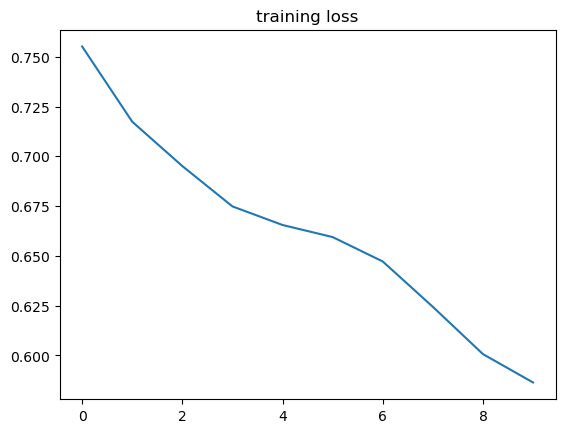

In [145]:
plt.plot(train_loss)
plt.title("training loss")
plt.show()

In [146]:
y_pred.min()

tensor(0.0123, grad_fn=<MinBackward1>)

In [147]:
y_pred.max()

tensor(0.4720, grad_fn=<MaxBackward1>)

In [148]:
loss_func

BCELoss()

In [149]:
y_pred.detach().numpy().ravel()

array([0.34174478, 0.47196528, 0.47196528, ..., 0.03625223, 0.47196528,
       0.16576307], dtype=float32)

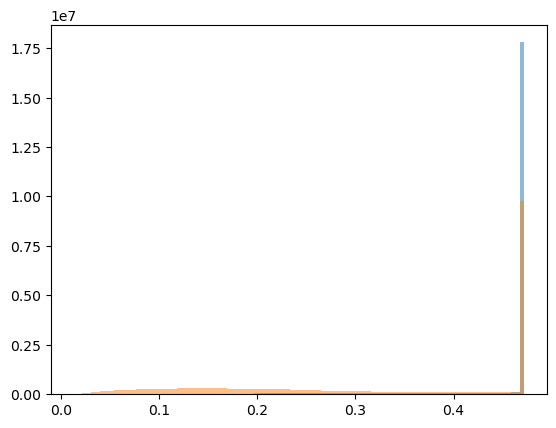

In [150]:
plt.hist(y_pred.detach().numpy().ravel()[y_dev == 1], bins = 100, alpha = 0.5)
plt.hist(y_pred.detach().numpy().ravel()[y_dev == 0], bins = 100, alpha = 0.5)
plt.show()

In [151]:
y_test_pred = t(torch.tensor(X_test[training_vars].values, dtype=torch.float32)) 

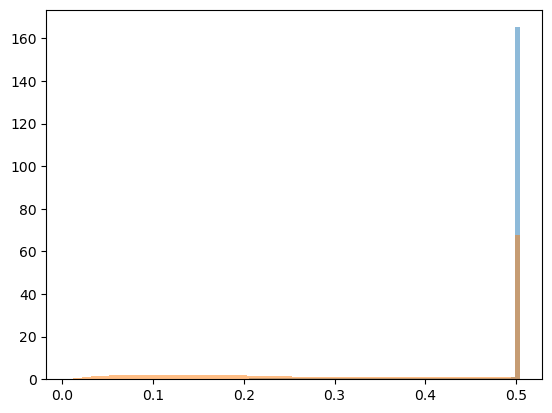

In [152]:
plt.hist(y_test_pred.detach().numpy().ravel()[y_test == 1], bins = 101, alpha = 0.5, density= True)
plt.hist(y_test_pred.detach().numpy().ravel()[y_test == 0], bins = 101, alpha = 0.5, density= True)
plt.show()

In [109]:
class TorchStandardScaler:
  def fit(self, x):
    self.mean = x.mean(0, keepdim=True)
    self.std = x.std(0, unbiased=False, keepdim=True)
  def transform(self, x):
    x -= self.mean
    x /= (self.std + 1e-7)
    return x

data = torch.tensor([[0, 0], [0, 0], [1, 1], [1, 1]]).float()
foo = TorchStandardScaler()
foo.fit(data)
print(f"mean {foo.mean}, std {foo.std}")


mean tensor([[0.5000, 0.5000]]), std tensor([[0.5000, 0.5000]])


In [110]:
foo.transform(data)

tensor([[-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [ 1.0000,  1.0000],
        [ 1.0000,  1.0000]])